# Նախագիծ [Auto.am](https://auto.am/) կայքից ավտոմեքենաների տվյալների հավաքագրման համար
#
### Նկարագրություն․
 Այս ֆայլը պարունակում է ավտոմեքենաների հիմնական տվյալներ՝
 * ավտոմեքենաների մակնիշները,
 * արտադրության տարին,
 * գինը ԱՄՆ դոլարով,
 * վազքը,
 * մեքենայի տարիքը:
### Տվյալները հավաքագրվել են [Auto.am](https://auto.am/) կայքից Selenium և Python տեխնոլոգիաների միջոցով:
 - Հավաքագրման գործընթացը ներառում է էջերի անցում, քարտերի որոնում, տվյալների մշակում և մաքրում
 - Վերջնական DataFrame-ը մաքրվում է և պահվում CSV ֆայլում հետագա վերլուծության կամ մեքենայական ուսուցման համար
#
### Ֆայլի սյուներ՝
* Մակնիշ       - Մեքենայի արտադրող/մակնիշը
* Տարեթիվ      - Մեքենայի արտադրության տարեթիվը
* Գին_USD      - Մեքենայի գինը ԱՄՆ դոլարով
* Վազք         - Մեքենայի վազքը (կմ)
* Մեքենայի_տարիք - Մեքենայի տարիքը հաշվարկված արտադրության տարեթվից
#
#

# Անհրաժեշտ գրադարանների և գործիքների տեղադրում

Այս հատվածում կատարվում է աշխատանքային միջավայրի կարգավորումը, անհրաժեշտ ծրագրային ապահովման տեղադրումը և վերլուծության համար պահանջվող գրադարանների ներմուծումը։

In [ ]:
print("📦 Տեղադրվում են գրադարանները...")
!apt-get update
!apt-get install -y wget curl unzip fonts-dejavu-core
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!apt install -y ./google-chrome-stable_current_amd64.deb
!pip install selenium webdriver-manager xgboost -q

import pandas as pd
import numpy as np
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import json
import urllib.parse
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from google.colab import files
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')

print("\n ✅ Տեղադրումը հաջողությամբ ավարտվեց")


📦 Տեղադրվում են գրադարանները...
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://dl.google.com/linux/chrome/deb stable InRelease [1,825 B]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://dl.google.com/linux/chrome/deb stable/main amd64 Packages [1,213 B]
Fetched 3,038 B in 1s (2,671 B/s)
Reading pac

# Selenium-ի կարգավորում և տվյալների հավաքագրում (Web Scraping)

Այս հատվածում իրականացվում է բրաուզերի ավտոմատացված կառավարումը՝ Auto.am կայքից իրական ժամանակում տվյալներ քաղելու համար։

In [ ]:

plt.rcParams['font.family'] = 'DejaVu Sans'

chrome_options = Options()
chrome_options.add_argument("--headless=new")
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36")
chrome_options.page_load_strategy = "eager"
chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
chrome_options.add_experimental_option("useAutomationExtension", False)

chrome_options.add_argument("--disable-blink-features=AutomationControlled")

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)
driver.set_page_load_timeout(30)

driver.execute_cdp_cmd(
    "Page.addScriptToEvaluateOnNewDocument",
    {
        "source": """
        Object.defineProperty(navigator, 'webdriver', {
            get: () => undefined
        })
        """
    },
)

print("✅ Selenium-ը հաջողությամբ միացավ:")

def scrape_data(pages=2):
    results = []
    print(f"🚀 Սկսվում է տվյալների հավաքագրումը Auto.am-ից...")

    for page in range(1, pages + 1):
        try:
            query = {"category":"1","page":page,"sort":"latest","layout":"list"}
            query["page"] = str(page)
            url = f"https://auto.am/search/passenger-cars?q={urllib.parse.quote(json.dumps(query))}"
            print(url)

            driver.get(url)
            WebDriverWait(driver, 20).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='card ']"))
            )

            cards = driver.find_elements(By.CSS_SELECTOR, "div[class='card ']")
            if not cards:
                print(f"⚠️ Էջ {page}-ում քարտեր չգտնվեցին:")
                continue

            for card in cards:
                try:
                    title_element = card.find_element(By.CSS_SELECTOR, '.card-title')
                    year_element = title_element.find_element(By.CSS_SELECTOR, 'span.grey-text')
                    year = year_element.text.strip()
                    model = title_element.text.replace(year, '').strip()

                    price_element = card.find_element(By.CSS_SELECTOR, '.card-action .price span')
                    price = price_element.text.strip()

                    try:
                        mileage_element = card.find_element(By.CSS_SELECTOR, '.card-desc strong')
                        mileage = mileage_element.text.strip()
                    except:
                        mileage = None

                    results.append({'title': model, 'year_text': year, 'price': price, 'mileage': mileage})
                except:
                    continue


            print(f"✅ Էջ {page}-ը սկանավորվեց: Գտնվել է {len(cards)} մեքենա:")
        except Exception as e:
            print(f"⚠️ Սխալ էջում: {e}")

    return pd.DataFrame(results)

df_raw = scrape_data(pages=5)
driver.quit()

✅ Selenium-ը հաջողությամբ միացավ:
🚀 Սկսվում է տվյալների հավաքագրումը Auto.am-ից...
https://auto.am/search/passenger-cars?q=%7B%22category%22%3A%20%221%22%2C%20%22page%22%3A%20%221%22%2C%20%22sort%22%3A%20%22latest%22%2C%20%22layout%22%3A%20%22list%22%7D
✅ Էջ 1-ը սկանավորվեց: Գտնվել է 47 մեքենա:
https://auto.am/search/passenger-cars?q=%7B%22category%22%3A%20%221%22%2C%20%22page%22%3A%20%222%22%2C%20%22sort%22%3A%20%22latest%22%2C%20%22layout%22%3A%20%22list%22%7D
✅ Էջ 2-ը սկանավորվեց: Գտնվել է 49 մեքենա:
https://auto.am/search/passenger-cars?q=%7B%22category%22%3A%20%221%22%2C%20%22page%22%3A%20%223%22%2C%20%22sort%22%3A%20%22latest%22%2C%20%22layout%22%3A%20%22list%22%7D
✅ Էջ 3-ը սկանավորվեց: Գտնվել է 47 մեքենա:
https://auto.am/search/passenger-cars?q=%7B%22category%22%3A%20%221%22%2C%20%22page%22%3A%20%224%22%2C%20%22sort%22%3A%20%22latest%22%2C%20%22layout%22%3A%20%22list%22%7D
✅ Էջ 4-ը սկանավորվեց: Գտնվել է 50 մեքենա:
https://auto.am/search/passenger-cars?q=%7B%22category%22%3A%20%2

# Տվյալների մաքրում և վերամշակում (Data Cleaning)

Սկզբնական տվյալները (raw data) հաճախ պարունակում են տեքստային սիմվոլներ, դատարկ վանդակներ կամ ոչ հարմար ձևաչափեր։ Այս հատվածում իրականացվում է տվյալների «զտումը», որպեսզի դրանք դառնան պիտանի վիզուալիզացիայի և մեքենայական ուսուցման համար։

In [ ]:

def clean_data(df):
    if df.empty: return df

    def to_num(x):
        nums = re.sub(r'[^\d]', '', str(x).replace(' ', ''))
        return float(nums) if nums else np.nan

    df['Գին_USD'] = df['price'].apply(lambda x: to_num(x) if '$' in str(x) else to_num(x)/400)
    df['Տարեթիվ'] = df['year_text'].apply(to_num)
    df['Վազք'] = df['mileage'].apply(to_num)
    df['Մակնիշ'] = df['title'].apply(lambda x: str(x).split(' ')[0].strip())
    df['Մեքենայի_տարիք'] = 2025 - df['Տարեթիվ']

    print("\n✅ Տվյալները հաջողությամբ մաքրվեցին")

    return df.dropna(subset=['Գին_USD', 'Տարեթիվ'])

print("\n🧹 Մաքրվում են տվյալները...")
df_clean = clean_data(df_raw.copy())


🧹 Մաքրվում են տվյալները...


# Տվյալների վալիդացիա և ավտոմատ պահպանում

Այս փուլում ծրագիրը ստուգում է հավաքագրված տվյալների որակը և ապահովում դրանց հուսալի պահպանումը տարբեր տեղերում։

In [ ]:

if df_clean.empty or len(df_clean) < 10:
    print("⚠️ Իրական տվյալները բավարար չեն: Գեներացվում են սիմուլյացիոն տվյալներ...")
    mock_data = {
        'Մակնիշ': np.random.choice(['Audi', 'BMW', 'Mercedes', 'Toyota', 'Nissan'], 200),
        'Տարեթիվ': np.random.randint(2005, 2024, 200),
        'Գին_USD': np.random.randint(5000, 65000, 200),
        'Վազք': np.random.randint(1000, 200000, 200)
    }
    df_clean = pd.DataFrame(mock_data)
    df_clean['Մեքենայի_տարիք'] = 2025 - df_clean['Տարեթիվ']
else:
  timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

  df_clean.to_csv(f"auto_am_data_{timestamp}.csv", index=False, encoding="utf-8-sig")
  filename = f"/content/drive/MyDrive/auto_am_data_{timestamp}.csv"
  df_clean.to_csv(filename, index=False, encoding="utf-8-sig")
  files.download(f"auto_am_data_{timestamp}.csv")

  print("✅ Տվյալները հաջողությամբ անցան ստւգումը և պահպանված են համակարգչում և Google Drive-ում")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Տվյալները հաջողությամբ անցան ստւգումը և պահպանված են համակարգչում և Google Drive-ում


## Գների բաշխման հիստոգրամ

**Նկարագրություն**: Այս գծապատկերը ցույց է տալիս շուկայում առկա ավտոմեքենաների գների հաճախականությունը։ KDE (կորագիծ) գիծն օգնում է տեսնել գների ընդհանուր միտումը։ Այն թույլ է տալիս հասկանալ՝ արդյոք գերակշռում են էկոնոմ դասի, թե պրեմիում դասի մեքենաները։

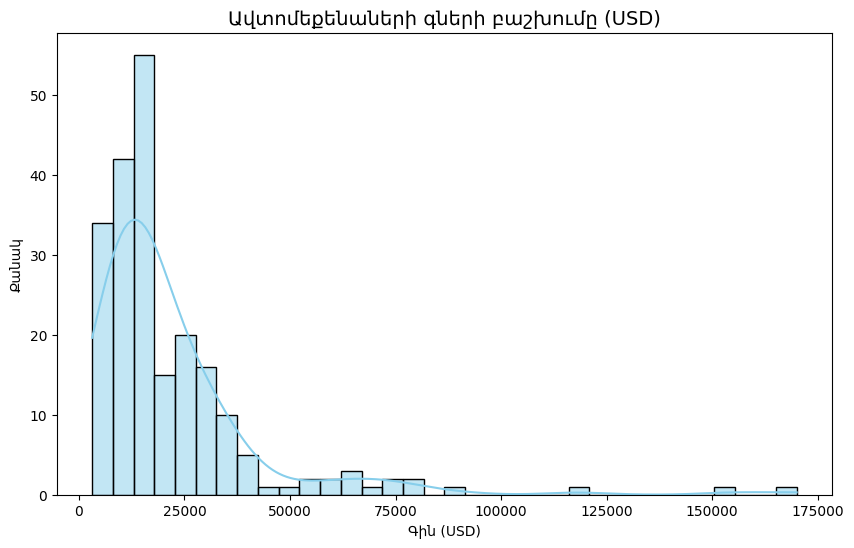

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Գին_USD'], kde=True, color='skyblue')
plt.title('Ավտոմեքենաների գների բաշխումը (USD)', fontsize=14)
plt.xlabel('Գին (USD)')
plt.ylabel('Քանակ')
plt.savefig('price_dist.png')

## Վազքի բաշխման հիստոգրամ

**Նկարագրություն**: Ցույց է տալիս մեքենաների օգտագործվածության աստիճանը (քանի կիլոմետր են քշված)։ Սա կարևոր է հասկանալու համար, թե որքանով է թարմ վաճառվող մեքենաների պարկը։

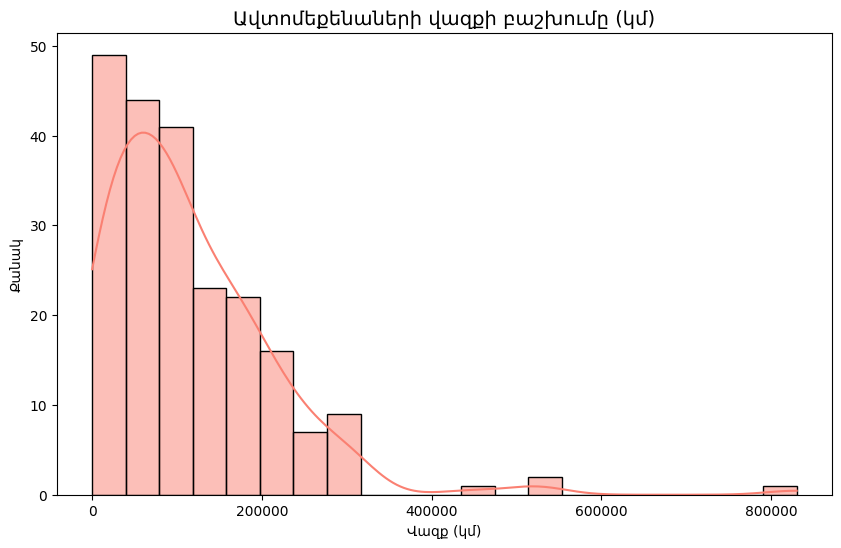

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Վազք'], kde=True, color='salmon')
plt.title('Ավտոմեքենաների վազքի բաշխումը (կմ)', fontsize=14)
plt.xlabel('Վազք (կմ)')
plt.ylabel('Քանակ')
plt.savefig('mileage_dist.png')

## Մակնիշների քանակի սյունակաձև գծապատկեր

**Նկարագրություն**: Սյունակների միջոցով ներկայացված է յուրաքանչյուր բրենդի (մակնիշի) տարածվածությունը տվյալների բազայում։ Առաջին հայացքից երևում է, թե որ արտադրողի մեքենաներն են ամենաշատը վաճառվում։

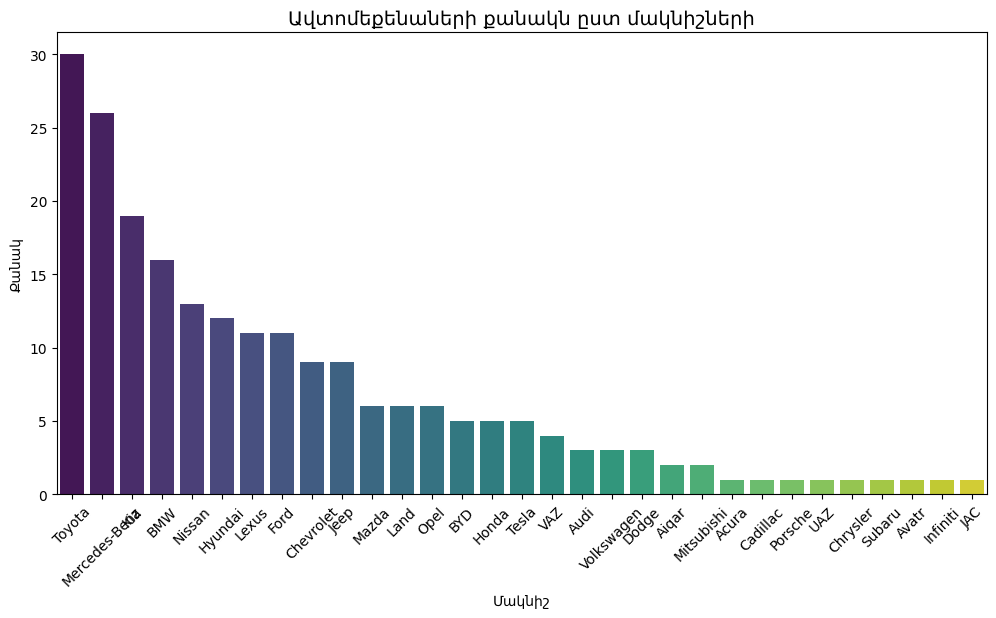

In [ ]:
plt.figure(figsize=(12, 6))
brand_counts = df_clean['Մակնիշ'].value_counts()
sns.barplot(x=brand_counts.index, y=brand_counts.values, palette='viridis', legend=False, hue=brand_counts.index,)
plt.title('Ավտոմեքենաների քանակն ըստ մակնիշների', fontsize=14)
plt.xticks(rotation=45)
plt.xlabel('Մակնիշ')
plt.ylabel('Քանակ')
plt.savefig('brand_count.png')

## Տարիքի բաշխման հիստոգրամ

**Նկարագրություն**: Այս գրաֆիկը պատկերում է մեքենաների տարիքային կազմը։ Այն օգնում է պարզել՝ արդյոք շուկայում շատ են հին մեքենաները, թե գերակշռում են նոր մոդելները։

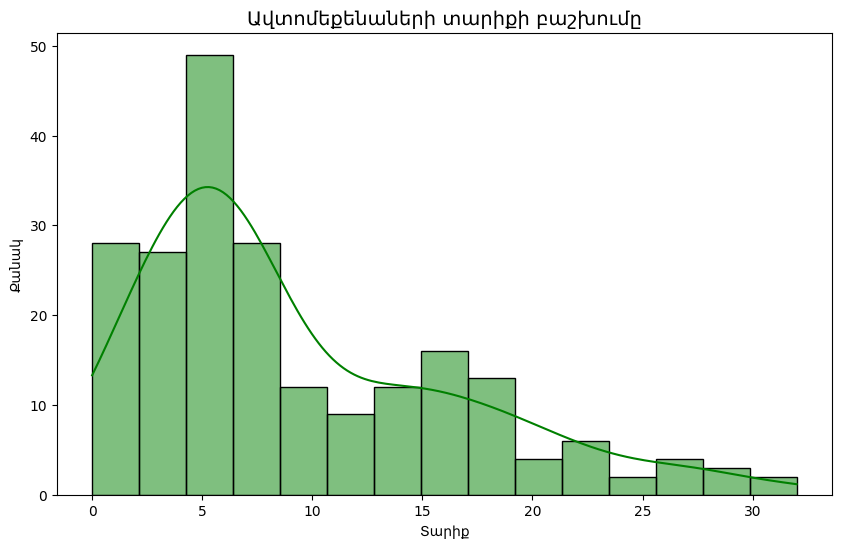

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Մեքենայի_տարիք'], bins=15, kde=True, color='green')
plt.title('Ավտոմեքենաների տարիքի բաշխումը', fontsize=14)
plt.xlabel('Տարիք')
plt.ylabel('Քանակ')
plt.savefig('age_dist.png')

## Սկատեր պլոտ: Գին vs Տարիք

**Նկարագրություն**: Ցույց է տալիս կապը մեքենայի տարիքի և դրա վաճառքի գնի միջև։ Սովորաբար կարելի է տեսնել գնանկման հստակ միտումը՝ որքան մեծ է մեքենայի տարիքը, այնքան ցածր է դրա գինը։

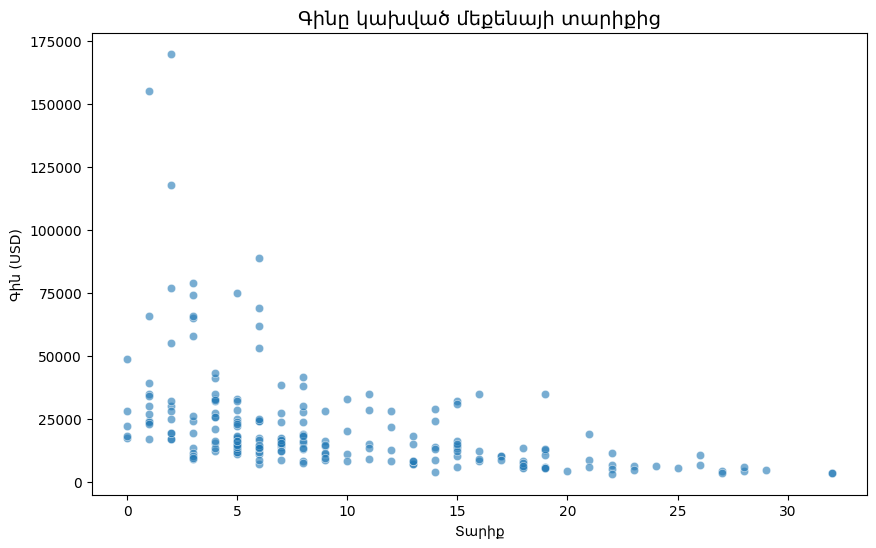

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Մեքենայի_տարիք', y='Գին_USD', alpha=0.6)
plt.title('Գինը կախված մեքենայի տարիքից', fontsize=14)
plt.xlabel('Տարիք')
plt.ylabel('Գին (USD)')
plt.savefig('price_vs_age.png')

## Սկատեր պլոտ: Գին vs Վազք

**Նկարագրություն**: Այս գծապատկերը վիզուալիզացնում է, թե ինչպես է մեքենայի անցած ճանապարհը (վազքը) ազդում դրա արժեքի վրա։ Կետերի դասավորվածությունը հուշում է կորելացիայի ուժգնության մասին։

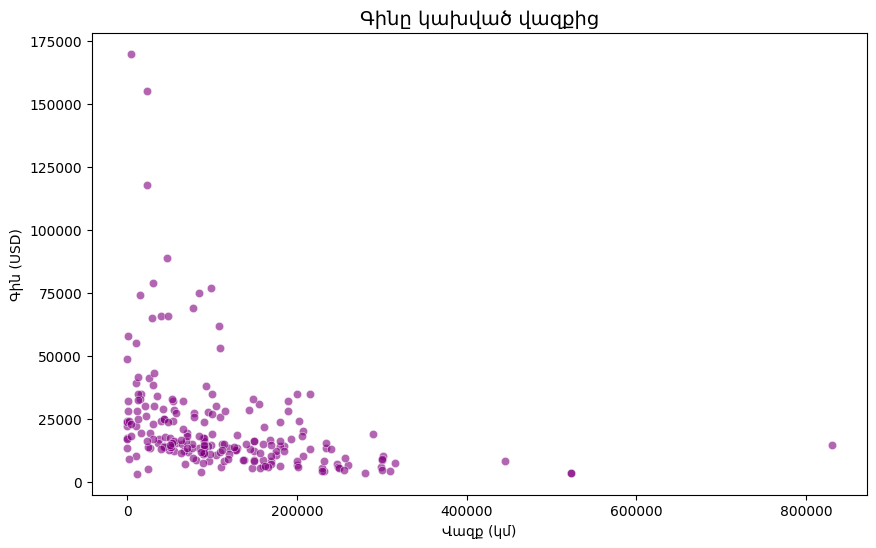

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Վազք', y='Գին_USD', alpha=0.6, color='purple')
plt.title('Գինը կախված վազքից', fontsize=14)
plt.xlabel('Վազք (կմ)')
plt.ylabel('Գին (USD)')
plt.savefig('price_vs_mileage.png')

## Box Plot: Գները ըստ թոփ 10 մակնիշների

**Նկարագրություն**: Այս գծապատկերը ցույց է տալիս գների "տիրույթը" (մինիմում, մաքսիմում, մեդիան) ամենատարածված 10 մակնիշների համար։ Այն թույլ է տալիս տեսնել գների տատանումները և "անոմալիաները" (outliers) յուրաքանչյուր բրենդի ներսում։

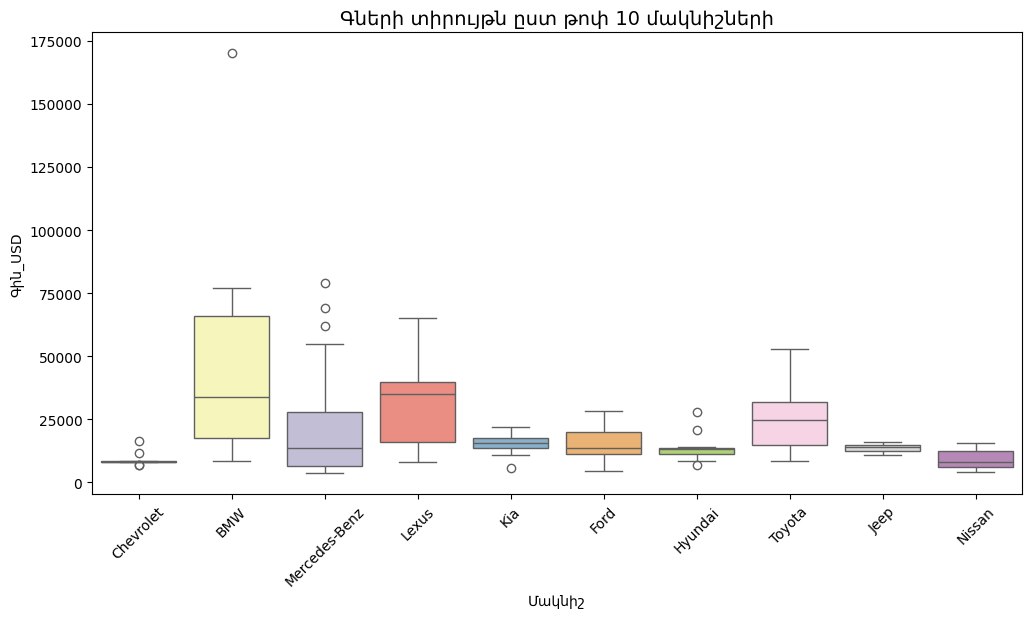

In [ ]:
top_10_brands = df_clean['Մակնիշ'].value_counts().nlargest(10).index
df_top_brands = df_clean[df_clean['Մակնիշ'].isin(top_10_brands)]
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_brands, x='Մակնիշ', hue='Մակնիշ', legend=False, y='Գին_USD', palette='Set3')
plt.title('Գների տիրույթն ըստ թոփ 10 մակնիշների', fontsize=14)
plt.xticks(rotation=45)
plt.savefig('price_by_brand_box.png')

## Միջին գինն ըստ մակնիշների

**Նկարագրություն**: Այստեղ ներկայացված է յուրաքանչյուր մակնիշի մեքենայի միջին շուկայական արժեքը։ Սա լավագույն միջոցն է տեսնելու համար, թե որ բրենդներն են համարվում ամենաթանկարժեքը տվյալ շուկայում։

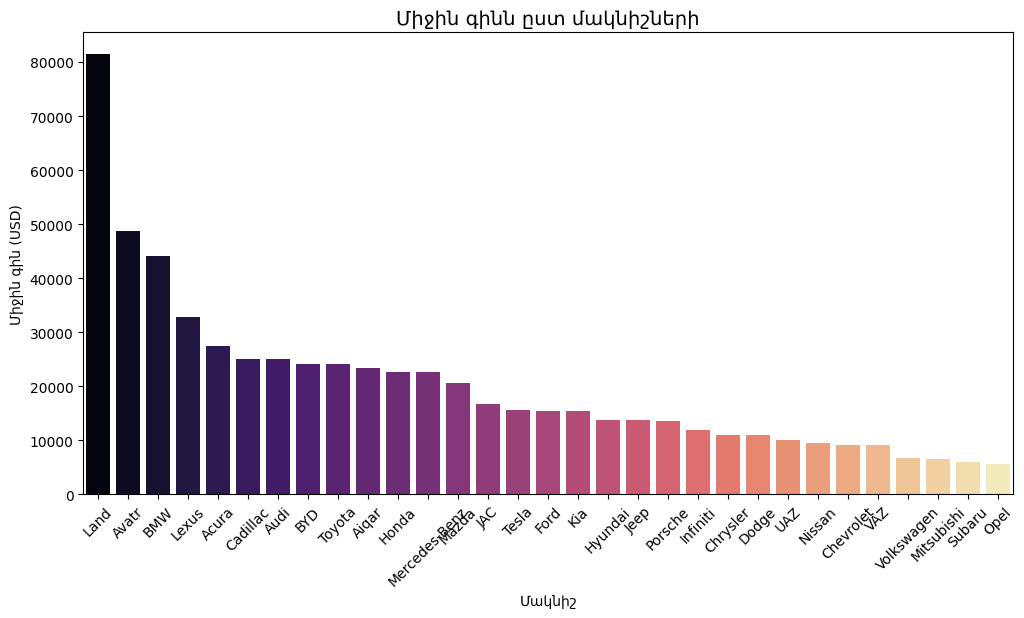

In [ ]:
avg_price = df_clean.groupby('Մակնիշ')['Գին_USD'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_price.index, y=avg_price.values, hue=avg_price.index, legend=False, palette='magma')
plt.title('Միջին գինն ըստ մակնիշների', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Միջին գին (USD)')
plt.savefig('avg_price_by_brand.png')

## Մեքենաների քանակն ըստ տարեթվերի

**Նկարագրություն**: Ժամանակագրական հաջորդականությամբ ցույց է տալիս, թե որ տարեթվի արտադրության մեքենաներն են ավելի շատ ներկայացված։ Օգնում է տեսնել արտադրության "պիկ" տարեթվերը։

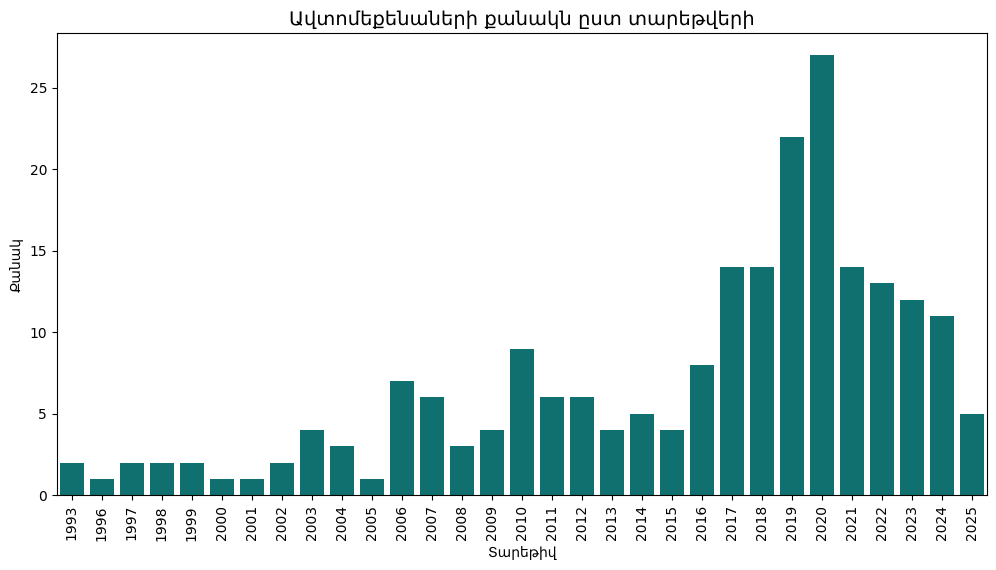

In [ ]:
year_counts = df_clean['Տարեթիվ'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=year_counts.index.astype(int), y=year_counts.values, color='teal')
plt.title('Ավտոմեքենաների քանակն ըստ տարեթվերի', fontsize=14)
plt.xticks(rotation=90)
plt.xlabel('Տարեթիվ')
plt.ylabel('Քանակ')
plt.savefig('cars_by_year.png')

## Թոփ 10 ամենատարածված մոդելները

**Նկարագրություն**: Այս գծապատկերը ներկայացնում է այն կոնկրետ մոդելները (օրինակ՝ Toyota Camry, BMW X5 և այլն), որոնք ամենահաճախն են հանդիպում հայտարարություններում։

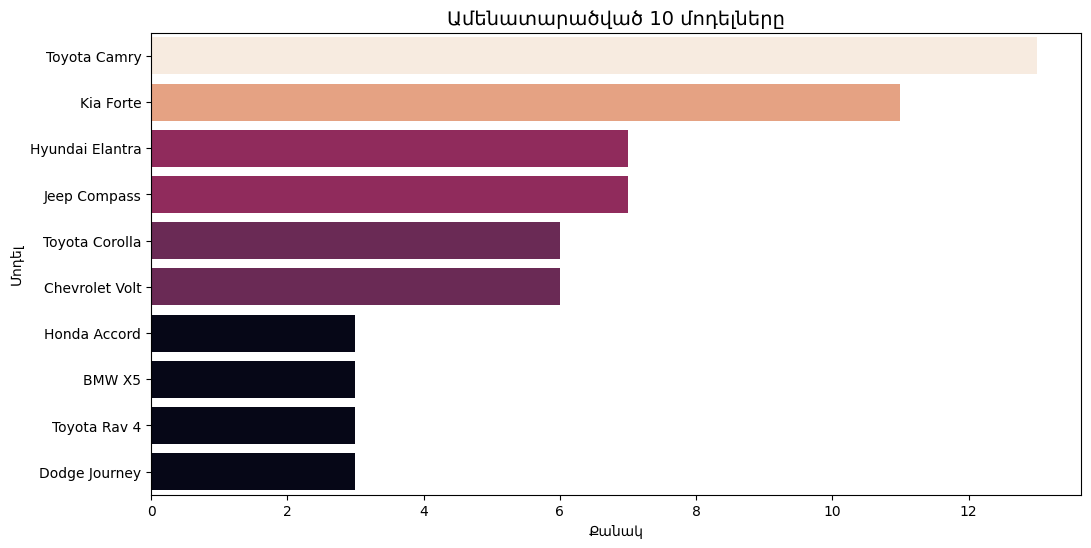

In [ ]:
model_counts = df_clean['title'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=model_counts.values, y=model_counts.index, palette='rocket', legend=False, hue=model_counts.values)
plt.title('Ամենատարածված 10 մոդելները', fontsize=14)
plt.xlabel('Քանակ')
plt.ylabel('Մոդել')
plt.savefig('top_models.png')

# 1. Գների կանխատեսման մոդել ( մեքենայական ուսուցում)
Օգտագործելով Random Forest Regressor, ես ստեղծեցի մոդել, որը փորձում է կանխատեսել մեքենայի գինը՝ հիմնվելով դրա տարիքի, վազքի և մակնիշի վրա:

* Իրական vs Կանխատեսված գին (actual_vs_predicted.png): Այս գծապատկերը ցույց է
տալիս, թե որքանով է մոդելը մոտ իրականությանը: Կարմիր գիծը կատարյալ կանխատեսումն է. որքան կետերը մոտ են գծին, այնքան մոդելն ավելի ճշգրիտ է:

* Գործոնների կարևորություն (feature_importance.png): Այստեղ կարող ենք տեսնել, թե որ փոփոխականն է ամենաշատն ազդում գնագոյացման վրա (օրինակ՝ տարիքը, թե կոնկրետ մակնիշը)

# 2. Փոխկապակցվածության մատրիցա (Correlation Heatmap)

* correlation_heatmap.png: Այս գծապատկերը ցույց է տալիս բոլոր թվային տվյալների միջև եղած կապերը: Օրինակ՝ ինչքանով են վազքը և տարիքը կապված գնի հետ: Կարմիր գույնը նշանակում է ուժեղ դրական կապ, կապույտը՝ բացասական:

# 3. Համատեղ բաշխման գծապատկեր (Joint Plot)

* joint_price_age.png: Սա շատ տպավորիչ գրաֆիկ է, որը միաժամանակ ցույց է տալիս և՛ գնի ու տարիքի կապը (ռեգրեսիոն գծով), և՛ դրանց առանձին բաշխումները հիստոգրամների տեսքով:

# 1. Տվյալների պատրաստում և մեքենայական ուսուցում

In [ ]:
df_ml = df_clean.copy()
top_brands = df_ml['Մակնիշ'].value_counts().nlargest(10).index
df_ml['Մակնիշ'] = df_ml['Մակնիշ'].apply(lambda x: x if x in top_brands else 'Other')
df_ml = pd.get_dummies(df_ml, columns=['Մակնիշ'], drop_first=True)

X = df_ml.drop(['title', 'year_text', 'price', 'mileage', 'Գին_USD', 'Տարեթիվ'], axis=1)
y = df_ml['Գին_USD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Մոդելի ուսուցում

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 3. Իրական vs Կանխատեսված գների գրաֆիկ

**Նկարագրություն**: Այս սկատեր պլոտը համեմատում է մոդելի կանխատեսած գները իրական շուկայական գների հետ։ Կարմիր կետագիծը ներկայացնում է «կատարյալ» կանխատեսումը։ Որքան կապույտ կետերը մոտ են կարմիր գծին, այնքան մոդելն ավելի ճշգրիտ է աշխատում։ Սա թույլ է տալիս տեսնել, թե որ գնային տիրույթներում է մոդելն ավելի լավ կամ վատ կանխատեսում։

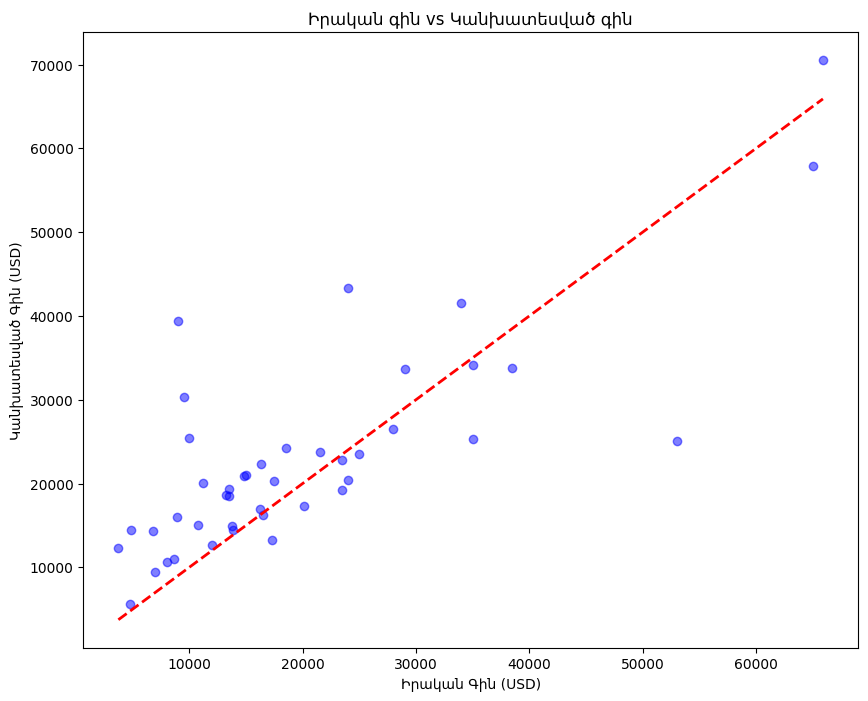

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Իրական գին vs Կանխատեսված գին')
plt.xlabel('Իրական Գին (USD)')
plt.ylabel('Կանխատեսված Գին (USD)')
plt.savefig('actual_vs_predicted.png')

## 4. Գործոնների ազդեցությունը գնի վրա (Feature Importance)

**Նկարագրություն**: Սա Random Forest մոդելի կողմից տրված գնահատականն է, թե որ տվյալներն են ամենաշատն ազդում մեքենայի վերջնական գնի վրա։ Օրինակ, կարող ենք տեսնել՝ արդյոք մեքենայի տարիքն ավելի կարևոր է գնագոյացման համար, թե վազքը կամ կոնկրետ մակնիշը։

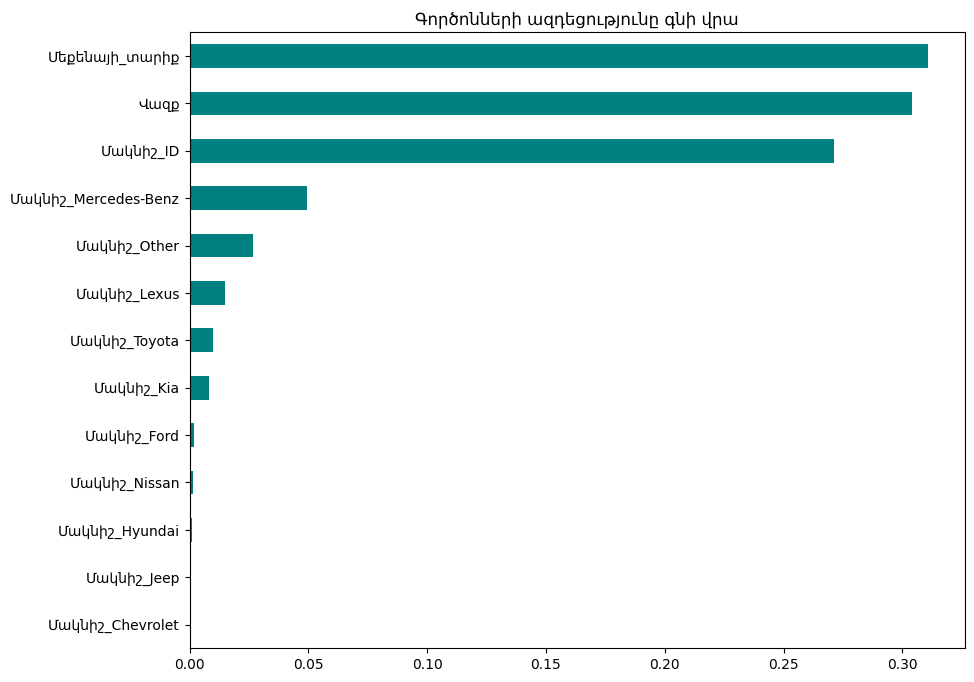

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(10, 8))
feat_importances.plot(kind='barh', color='teal')
plt.title('Գործոնների ազդեցությունը գնի վրա')
plt.savefig('feature_importance.png')

# 5. Փոփոխականների փոխկապակցվածության մատրիցա (Correlation Heatmap)

Նկարագրություն: Այս ջերմային քարտեզը (Heatmap) ցույց է տալիս բոլոր թվային տվյալների միջև եղած կապի ուժգնությունը։ Գործակիցները տատանվում են -1-ից մինչև +1։

* +1 (Կարմիր) - Ուժեղ դրական կապ (մեկը մեծանում է, մյուսն էլ է մեծանում)։

* -1 (Կապույտ) - Ուժեղ բացասական կապ (մեկը մեծանում է, մյուսը փոքրանում է)։

* 0 - Կապ չկա։

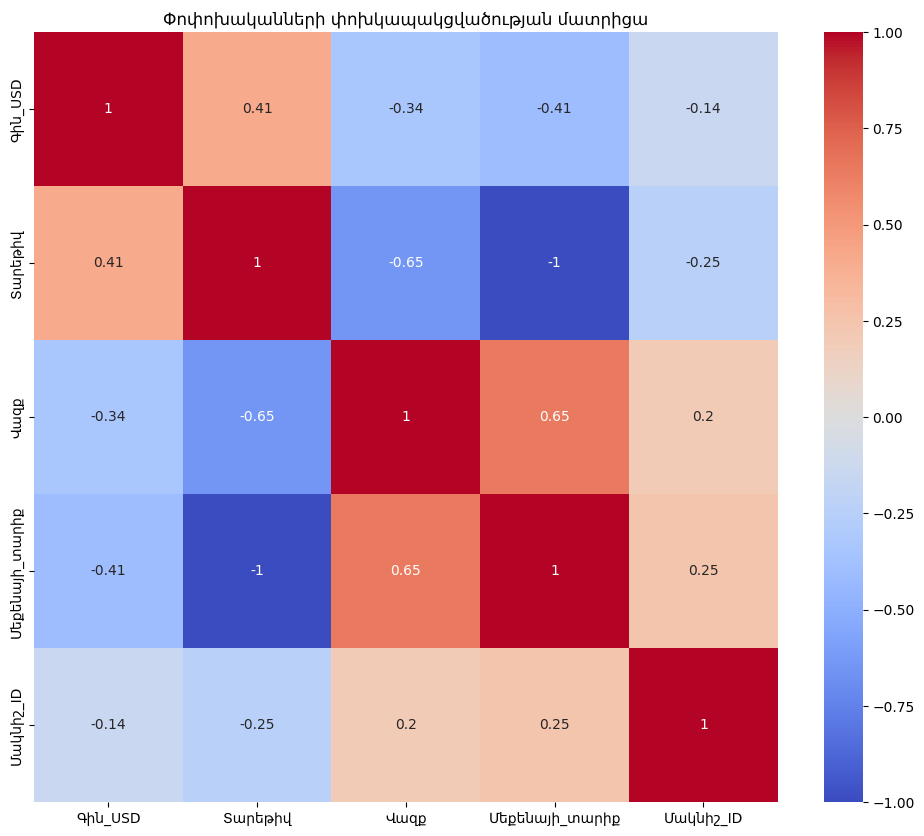

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title('Փոփոխականների փոխկապակցվածության մատրիցա')
plt.savefig('correlation_heatmap.png')

# 6. Գնի և Տարիքի կապը բաշխումներով (Joint Plot)

**Նկարագրություն**: Այս բարդ գծապատկերը միավորում է երկու կարևոր վերլուծություն.
#
#
#
1. Կենտրոնում սկատեր պլոտն է՝ ռեգրեսիոն գծով, որը ցույց է տալիս գնի և տարիքի
ընդհանուր տրենդը։

2. Վերևում և աջ կողմում տեղադրված են հիստոգրամները, որոնք ցույց են տալիս յուրաքանչյուր առանձին փոփոխականի բաշխվածությունը։

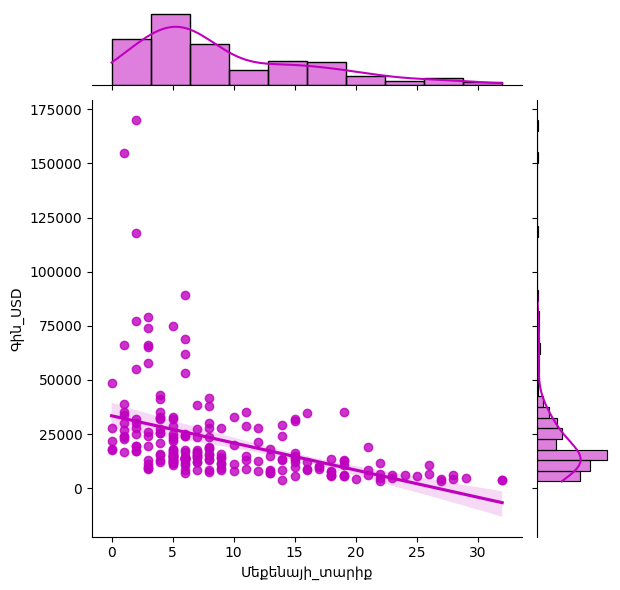

In [ ]:
g = sns.jointplot(data=df_clean, x='Մեքենայի_տարիք', y='Գին_USD', kind="reg", color="m")
plt.savefig('joint_price_age.png')

# Մոդելի հիմնական ցուցանիշները

1. **MAE (Mean Absolute Error)**: Միջին բացարձակ սխալ։ Ցույց է տալիս, թե միջինում քանի դոլարով է մեր մոդելը սխալվում կանխատեսման ժամանակ։

1. **R² Score**: Ճշգրտության գործակից։ Ցույց է տալիս, թե մեր ունեցած տվյալների (տարիք, վազք, մակնիշ) քանի տոկոսն է բացատրում գնի տատանումները։

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"--- Մոդելի գնահատման արդյունքները ---")
print(f"Միջին բացարձակ սխալ (MAE): {mae:,.2f} USD")
print(f"Բացատրություն: Միջինում մոդելը սխալվում է {mae:,.0f} դոլարի չափով:")
print(f"------------------------------------")
print(f"Ճշգրտության գործակից (R2 Score): {r2:.2f}")

if r2 < 0.5:
    print("\nՀուշում. Ավելի բարձր ճշգրտության համար մեզ անհրաժեշտ կլինեն լրացուցիչ տվյալներ (օրինակ՝ շարժիչի հզորություն, վիճակ, գույն):")

--- Մոդելի գնահատման արդյունքները ---
Միջին բացարձակ սխալ (MAE): 6,377.40 USD
Բացատրություն: Միջինում մոդելը սխալվում է 6,377 դոլարի չափով:
------------------------------------
Ճշգրտության գործակից (R2 Score): 0.58
